# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete GFE-constrained SSM.

TODO: parameter estimation

In [1]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [2]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

# Regulator Model

In [3]:
T = 2

fg_plan = FactorGraph()

u = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV x_t_min ~ Categorical(placeholder(:D_t_min, dims=(8,)))

x_k_min = x_t_min
for k=1:T
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k])

    placeholder(u[k], :u, index=k, dims=(8,8))
    DiscreteObservation(x[k], 
                   placeholder(:A, dims=(16,8), var_id=:A_*k), 
                   placeholder(:C, dims=(16,), index=k, var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k]
end
;

In [5]:
q_plan = PosteriorFactorization(fg_plan)
algo_plan = messagePassingAlgorithm(x_t_min, id=:Plan, free_energy=true)
code_plan = algorithmSourceCode(algo_plan, free_energy=true)
eval(Meta.parse(code_plan))
;

# Estimator Model

In [6]:
fg_slide = FactorGraph()

u = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV x_t_min ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV x_t ~ Transition(x_t_min, placeholder(:B_t, dims=(8,8)))
@RV y_t ~ Transition(x_t, placeholder(:A, dims=(16,8)))
placeholder(y_t, :o_t, dims=(16,))
;

In [7]:
q_slide = PosteriorFactorization(fg_slide)
algo_slide = messagePassingAlgorithm(x_t, id=:Slide)
code_slide = algorithmSourceCode(algo_slide)
eval(Meta.parse(code_slide))
;

# Results

In [13]:
α = 0.9; c = 2.0 # Reward probability and utility
N = 2 # Number of moves per simulation
S = 10 # Number of simulations

include("environment.jl")
include("agent.jl")
include("helpers.jl")

(A, B, C, D) = constructABCD(α, c)
C_t = [C, C] # Goal prior sequence
;

## Action-Perception Loop

In [18]:
        
# for s = 1:S
    (execute, observe) = initializeWorld(A, B, C, D) # Let there be a world
    (plan, act, slide) = initializeAgent(A, B, C, D) # Let there be a constrained agent

    # Step through the experimental protocol
    G_ts = Vector{Matrix}(undef, N)
    a = Vector{Int64}(undef, N)
    for t = 1:N
           G_ts[t] = plan()
              a[t] = act(G_ts[t])
                     execute(a[t])
        (o_t, r_t) = observe()
                     slide(a[t], o_t)
    end
# end
;

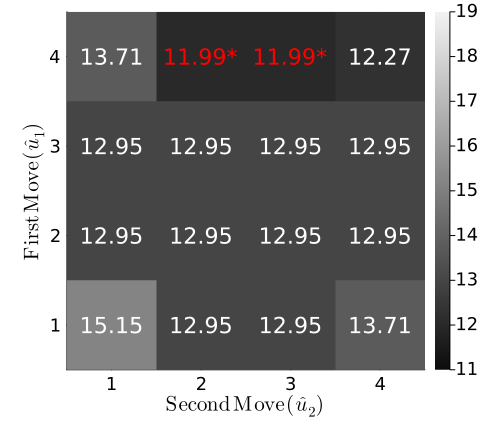

In [22]:
plotResults(G_ts[1], clim=(11,19), highlight=minimum)

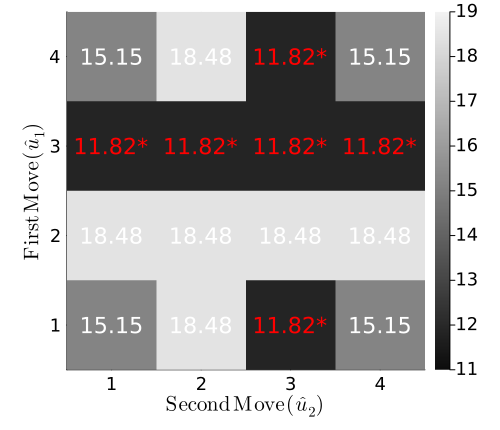

In [23]:
plotResults(G_ts[2], clim=(11,19), highlight=minimum)

In [15]:
println(a) # Back to one?

[4, 1]
